In [1]:
%matplotlib inline


Задача переноса стиля на изображении
=============================


Введение
------------

В этом ноутбуке мы реализуем алгоритм переноса стиля из статьи https://arxiv.org/abs/1508.06576 Leon A. Gatys, Alexander S. Ecker, Matthias Bethge.

Перенос стиля (Neural-Style, Neural-Transfer) --- это процесс преобразования стиля исходного изображения к стилю выбранного изображения.

***Основной идеей алгоритма, описанного в ноутбуке, является то, что
признаки, полученные с помощью сверточной нейронной сети, можно использовать
для выделения содержательной и стилевой составляющих изображения.***

На вход алгоритму требуется три изображения:
* input-image - изменяемое входное изображение (обычно берется исходное изображение или белый шум)
* content-image - исходное изображение

* style-image - изображение, стиль которого будет использован


Алгоритм изменяет input-image таким образом, чтобы содержание было похоже на content-image, а стиль - на style-image.


Формализация идеи
--------------------

Мы определяем два расстояния (метрики):
* $D_C$ - расстояние между содержанием на изображениях (content distance)
* $D_S$ - расстояние между стилями на изображениях (style distance)

Затем берём изменяемое изображение (input-image) и трансформируем его так, чтобы на результирующем изображении минимизровались оба расстояния.


Импортируем необходимые библиотеки
-----------------------------------------

-  ``torch``, ``torch.nn``, ``numpy``
-  ``torch.optim``
-  ``PIL``, ``PIL.Image``, ``matplotlib.pyplot`` (загрузка и визуализация изображений)
-  ``torchvision.transforms`` (трансформирует PIL-изображения в тензоры)
-  ``torchvision.models`` 
-  ``copy`` 



In [6]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

Если возможно - запускаем алгоритм на GPU для ускорения вычислений:
``torch.cuda.is_available()``



In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Загружаем изображения

------------------

Загружаем стилевое изображение и изменяемое (content) изображение.

Исходные PIL-картинки содержат значения от 0 до 255, однако при их преобразовании в тензоры значения переходят на отрезок от 0 до 1.

Также изображения должны быть приведены к одинаковым размерам.

***Важно!*** В pytorch значения тензоров должны лежать на отрезке от 0 до 1. Если попробовать применить модель к тензору со значениями от 0 до 255, то в результате применения свёрток (feature maps) не получится корректно выделить содержание и стиль на изображении.

In [9]:
# Определим размер картины. Важно - чем больше размер, тем дольше будет перенос стиля. Используйте GPU.
imsize = 1024  

loader = transforms.Compose([
    transforms.Resize(imsize),  # изменение размеров изображения
    transforms.ToTensor()])  # переводим картинку в тензор


def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

!wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
!wget https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg

style_img = image_loader("picasso.jpg") # поместите сюда путь к картине, стиль которой хотите перенести
content_img = image_loader("dancing.jpg") # поместите сюда путь к картине, содержание которой хотите перенести

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

--2021-06-28 10:12:42--  https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114573 (112K) [image/jpeg]
Saving to: ‘picasso.jpg’

picasso.jpg         100%[===================>] 111.89K  --.-KB/s    in 0.1s    

2021-06-28 10:12:43 (934 KB/s) - ‘picasso.jpg’ saved [114573/114573]

--2021-06-28 10:12:43--  https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40484 (40K) [image/jpeg]
Saving to: ‘dancing.jpg’

dancing.jpg         100%[===================>]  39.54K  --.-KB/s    in 0.02s   

2021-06-28 10:12:44 (1.73 MB/s) - ‘dancing.jpg’ saved [40484/40484]



Создадим функцию, которая визуализирует изображение, копируя его и переводя обратно в PIL формат.


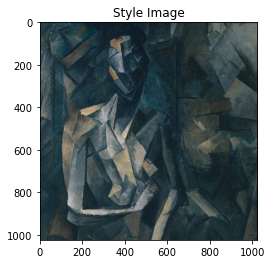

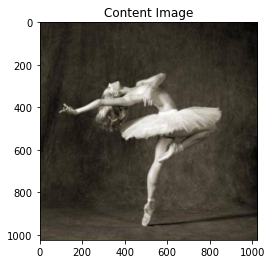

In [10]:
unloader = transforms.ToPILImage() 

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone() 
    image = image.squeeze(0)      
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

Функции потерь (Loss)
--------------

***Content Loss***

Content loss - взвешенный вариант content distance ($D_C$) для каждого свёрточного слоя сети.
* принимает на вход feature maps $F_{XL}$ для изображения $X$ и слоя $L$ сети
* возвращает взвешенное рассстояние $w_{CL}.D_C^L(X,C)$ между изображением $X$ и контентным изображением $C$.

Feature maps контентного изображения ($F_{CL}$) должны быть известны заранее для вычисления контентного расстояния:
$$D_C^L(X,C)=\|F_{XL} - F_{CL}\|^2$$ (для вычисления используем ``nn.MSELoss``).


In [11]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

**Style Loss**

Модуль Style loss выглядит похожим образом.

Чтобы вычислить style loss, необходимо вычислить матрицу Грама (матрицу скалярных произведений) $G_{XL}$. Матрица Грама - это результат умножения матрицы на её транспонированный вариант. 

В данном случае нам нужна матрица feature maps $F_{XL}$ для слоя $L$. Мы трансформируем матрицу $F_{XL}$, чтобы она имела размерность $K \times N$, где 
* $K$ - число feature maps на слое $L$
* $N$ - длина каждой вытянутой в вектор feature map $F_{XL}^k$.
Обозначим матрицу требуемой размерности $\hat{F}_{XL}$.

**Пояснение:**
например, первая строка матрицы $\hat{F}_{XL}$ соответствует первой feature map $F_{XL}^1$, вытянутой в вектор.

Наконец, мы нормализуем матрицу Грама путем деления каждого элемента на число элементов матрицы. 

**Зачем это нужно?**
Такая нормализация нужна потому, что матрицы $\hat{F}_{XL}$ с большой размерностью $N$ приводят к большим значениям в матрице Грама. Большие значения в свою очередь могут спровоцировать то, что первые сверточные слои (до применения pooling) будут иметь наибольший вклад в процесс градиентного спуска. Но стилевые признаки по большей части содержатся в глубоких слоях нейронной сети, поэтому эта нормализация важна.

In [12]:
def gram_matrix(input):
    a, b, c, d = input.size()  

    features = input.view(a * b, c * d)

    G = torch.mm(features, features.t()) 

    return G.div(a * b * c * d)

Style loss, аналогично content loss, вычисляется через квадрат расстояния между $G_{XL}$ and $G_{SL}$.




In [13]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

Импортируем модель
-------------------

Будем использовать предобученную нейронную сеть. Для этой задачи возьмём VGG19.

VGG в имплементации pytorch имеет две части:
* ``Sequential`` modules: ``features`` (содержит свёртки и пулинги)
* ``Classifier`` (содержит полносвязные слои). 

Мы будем пользоваться модулем ``features``, так как нам нужны результаты применения свёрток для вычисления контентного и стилевого лоссов.

Так как мы используем предобученную нейронную сеть и дообучать мы её не планируем, то мы ставим сеть в режим применения: ``.eval()``.


In [14]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/varsey-fabuza/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG сети обучены на нормализованных изображениях с параметрами mean=[0.485, 0.456, 0.406] и std=[0.229, 0.224, 0.225].
Поэтому перед подачей изображения в сеть его необходимо нормализовать таким же образом.



In [15]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

Теперь мы должны добавить к свёрточной части сети VGG19 стилевой и контентный лосс сразу после свёрточных слоёв.

Для этого необходимо создать новый модуль ``Sequential`` с добавленными в нужные места лоссами.



In [22]:
# пробуйте менять содержимое данных списков. Возможно, это поможет сделать более уникальные картины
content_layers_default = ['conv_2', 'conv_3']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0 
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Теперь выбираем input image. В качестве input image можно использовать, например, исходное (content) изображение или белый шум.



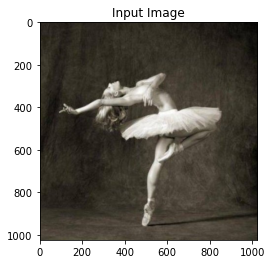

In [23]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

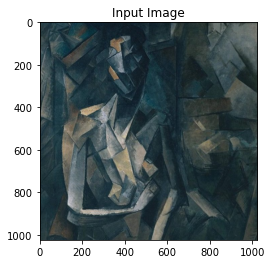

In [24]:
test_img = style_img.clone()

plt.figure()
imshow(test_img, title='Input Image')

Градиентный спуск
----------------

Как предложил автор алгоритма, мы будем использовать алгоритм
L-BFGS градиентного спуска. 

В данной версии алгоритма мы обучаем не веса в сети, а исходное изображение, чтобы минимизировать content/style
losses. Для этого используем pytorch ``optim.LBFGS`` и передаем наше изображение (как тензор) в оптимизатор.




In [25]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    # Попробуйте другие оптимизаторы, исследуйте, как это влияет на работу алгоритма. 
    # Однако помните, что LBFGS тут выбран не просто так
    return optimizer

Наконец, создадим функцию, осуществляющую стилевой перенос.
* на каждой итерации она получает на вход изображение и вычисляет новые значения лоссов (style/content).
* также на каждом шаге с помощью ``backward`` методов динамически вычисляются градиенты функций потерь. 

Также необходимо привести значения тензоров к отрезку $[0;1]$ на каждой итерации.



In [26]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 1 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

Запускаем алгоритм!

Building the style transfer model..


<ipython-input-15-9d08329ca7ea>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-15-9d08329ca7ea>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [1]:
Style Loss : 305.447449 Content Loss: 0.000000

run [2]:
Style Loss : 305.427185 Content Loss: 0.000000

run [3]:
Style Loss : 182.598679 Content Loss: 0.724617

run [4]:
Style Loss : 163.150726 Content Loss: 1.066727

run [5]:
Style Loss : 144.424088 Content Loss: 0.807794

run [6]:
Style Loss : 136.673019 Content Loss: 0.775963

run [7]:
Style Loss : 132.519089 Content Loss: 0.790190

run [8]:
Style Loss : 125.946388 Content Loss: 0.868702

run [9]:
Style Loss : 122.344734 Content Loss: 1.114394

run [10]:
Style Loss : 115.495224 Content Loss: 1.119610

run [11]:
Style Loss : 112.453804 Content Loss: 1.119694

run [12]:
Style Loss : 107.604576 Content Loss: 1.257365

run [13]:
Style Loss : 102.147049 Content Loss: 1.299854

run [14]:
Style Loss : 97.562180 Content Loss: 1.326298

run [15]:
Style Loss : 94.165604 Content Loss: 1.505818

run [16]:
Style Loss : 88.783859 Content Loss: 1.559163

run [17]:
Style Loss : 84.175812 Content Loss: 1.561241

run [18]:
Styl

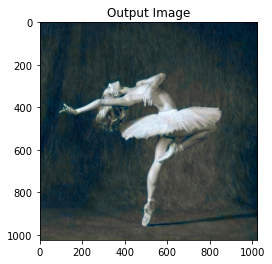

In [27]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, test_img, input_img, style_weight=500000,num_steps=20)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

#### Задание 1. 

Мы запустили алгоритм, используя в качестве input_image исходное изображение (content_image). Попробуйте в качестве input_image взять белый шум. Визуализируйте результат.

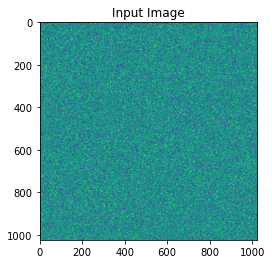

In [33]:
input_img = image_loader('/home/varsey-fabuza/Dropbox/my_training/radisson/white-noise.jpg')

plt.figure()
imshow(input_img, title='Input Image')

Building the style transfer model..


<ipython-input-15-9d08329ca7ea>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-15-9d08329ca7ea>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [1]:
Style Loss : 4.252394 Content Loss: 42.868568

run [2]:
Style Loss : 4.252226 Content Loss: 42.867714

run [3]:
Style Loss : 1.823670 Content Loss: 28.385092

run [4]:
Style Loss : 0.476411 Content Loss: 12.880131

run [5]:
Style Loss : 0.363914 Content Loss: 9.158621

run [6]:
Style Loss : 0.217364 Content Loss: 6.725728

run [7]:
Style Loss : 0.103371 Content Loss: 4.945151

run [8]:
Style Loss : 0.085670 Content Loss: 3.702625

run [9]:
Style Loss : 0.082150 Content Loss: 2.953450

run [10]:
Style Loss : 0.065138 Content Loss: 2.419844

run [11]:
Style Loss : 0.056487 Content Loss: 1.996989

run [12]:
Style Loss : 0.056489 Content Loss: 1.673427

run [13]:
Style Loss : 0.057561 Content Loss: 1.456135

run [14]:
Style Loss : 0.057145 Content Loss: 1.292342

run [15]:
Style Loss : 0.056803 Content Loss: 1.160364

run [16]:
Style Loss : 0.057606 Content Loss: 1.061420

run [17]:
Style Loss : 0.058464 Content Loss: 0.988771

run [18]:
Style Loss : 0.058863 Content 

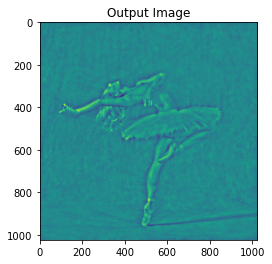

In [34]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, test_img, input_img, style_weight=100,num_steps=20)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

#### Задание 2.
Загрузите другую стилевую картинку (например, "звездную ночь" Ван Гога или любую другую), не забудьте привести её к тем же размерам, что и картинка с содержанием.

Примените новый стиль к изображению. Нравится ли вам результат?

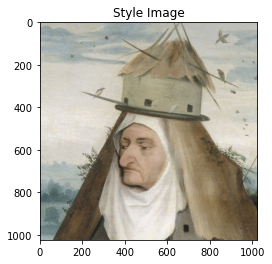

In [41]:
test_img_new = image_loader('/home/varsey-fabuza/Dropbox/my_training/radisson/bosch_cr.jpg')

plt.figure()
imshow(test_img_new, title='Style Image')

In [42]:
input_img = content_img.clone()

Building the style transfer model..


<ipython-input-15-9d08329ca7ea>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-15-9d08329ca7ea>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [1]:
Style Loss : 345.337311 Content Loss: 0.000000

run [2]:
Style Loss : 345.296295 Content Loss: 0.000000

run [3]:
Style Loss : 207.002548 Content Loss: 0.008988

run [4]:
Style Loss : 182.948349 Content Loss: 0.024364

run [5]:
Style Loss : 160.792740 Content Loss: 0.020186

run [6]:
Style Loss : 154.894897 Content Loss: 0.019837

run [7]:
Style Loss : 144.437073 Content Loss: 0.022331

run [8]:
Style Loss : 136.871918 Content Loss: 0.027128

run [9]:
Style Loss : 131.495560 Content Loss: 0.030803

run [10]:
Style Loss : 127.533714 Content Loss: 0.032292

run [11]:
Style Loss : 123.944862 Content Loss: 0.035251

run [12]:
Style Loss : 120.278145 Content Loss: 0.038730

run [13]:
Style Loss : 117.209198 Content Loss: 0.040952

run [14]:
Style Loss : 114.442413 Content Loss: 0.043039

run [15]:
Style Loss : 111.952644 Content Loss: 0.045738

run [16]:
Style Loss : 110.060577 Content Loss: 0.047479

run [17]:
Style Loss : 108.568047 Content Loss: 0.049124

run [18]:


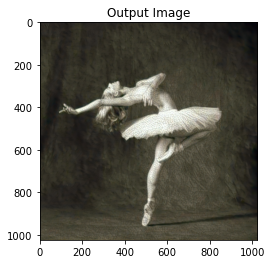

In [43]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, test_img_new, input_img, style_weight=1000000,
                            num_steps=20, content_weight=0.1)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

#### Задание 3.
Поэкспериментируйте с коэффициентами при style_loss и content_loss (по дефолту используются значения style_weight=1000000, content_weight=1).

Выведите на экран итоговые изображения для различных по порядку style_weight (используйте значения весов в диапазоне от 0 до 1).

Building the style transfer model..


<ipython-input-15-9d08329ca7ea>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-15-9d08329ca7ea>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [1]:
Style Loss : 448.559357 Content Loss: 0.242833

run [2]:
Style Loss : 448.546967 Content Loss: 0.242830

run [3]:
Style Loss : 446.613983 Content Loss: 0.241378

run [4]:
Style Loss : 445.317627 Content Loss: 0.240678

run [5]:
Style Loss : 444.392975 Content Loss: 0.239531

run [6]:
Style Loss : 443.280792 Content Loss: 0.237637

run [7]:
Style Loss : 441.978912 Content Loss: 0.235312

run [8]:
Style Loss : 440.465515 Content Loss: 0.233227

run [9]:
Style Loss : 439.272766 Content Loss: 0.232412

run [10]:
Style Loss : 438.319183 Content Loss: 0.231485

run [11]:
Style Loss : 437.177338 Content Loss: 0.230090

run [12]:
Style Loss : 435.950714 Content Loss: 0.229625

run [13]:
Style Loss : 434.857269 Content Loss: 0.228922

run [14]:
Style Loss : 433.568665 Content Loss: 0.227124

run [15]:
Style Loss : 432.207916 Content Loss: 0.226514

run [16]:
Style Loss : 431.151855 Content Loss: 0.226142

run [17]:
Style Loss : 429.818970 Content Loss: 0.225768

run [18]:


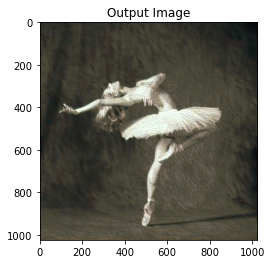

In [44]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, test_img, input_img, style_weight=5000000,
                            num_steps=20, content_weight=0.25)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

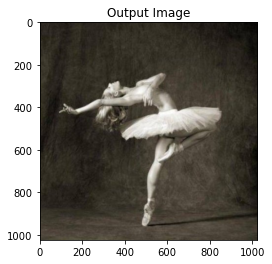

In [45]:
input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Output Image')

Building the style transfer model..


<ipython-input-15-9d08329ca7ea>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-15-9d08329ca7ea>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [1]:
Style Loss : 1.726687 Content Loss: 0.000000

run [2]:
Style Loss : 1.726481 Content Loss: 0.000000

run [3]:
Style Loss : 1.044116 Content Loss: 0.056276

run [4]:
Style Loss : 0.864093 Content Loss: 0.125995

run [5]:
Style Loss : 0.810454 Content Loss: 0.097094

run [6]:
Style Loss : 0.788229 Content Loss: 0.089504

run [7]:
Style Loss : 0.751751 Content Loss: 0.090469

run [8]:
Style Loss : 0.709274 Content Loss: 0.105336

run [9]:
Style Loss : 0.683924 Content Loss: 0.113356

run [10]:
Style Loss : 0.668570 Content Loss: 0.115939

run [11]:
Style Loss : 0.651268 Content Loss: 0.120727

run [12]:
Style Loss : 0.636475 Content Loss: 0.125097

run [13]:
Style Loss : 0.626556 Content Loss: 0.126758

run [14]:
Style Loss : 0.618134 Content Loss: 0.128389

run [15]:
Style Loss : 0.614320 Content Loss: 0.127236

run [16]:
Style Loss : 0.607546 Content Loss: 0.129660

run [17]:
Style Loss : 0.600604 Content Loss: 0.132634

run [18]:
Style Loss : 0.597058 Content Loss

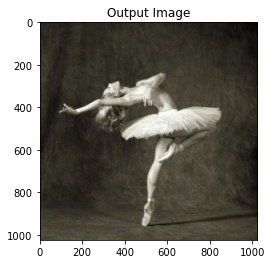

In [46]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, test_img, input_img, style_weight=5000,
                            num_steps=20, content_weight=0.7)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

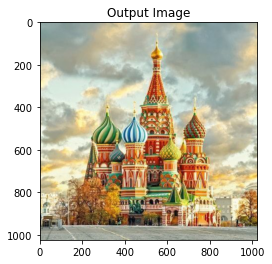

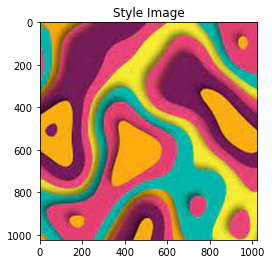

In [50]:
content_img = image_loader('/home/varsey-fabuza/Dropbox/my_training/radisson/kremlin_cr.jpg')

input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Output Image')

test_img = image_loader('/home/varsey-fabuza/Dropbox/my_training/radisson/anstraction_cr.jpg')
plt.figure()
imshow(test_img, title='Style Image')

Building the style transfer model..


<ipython-input-15-9d08329ca7ea>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-15-9d08329ca7ea>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [1]:
Style Loss : 4369.842773 Content Loss: 0.000000

run [2]:
Style Loss : 4369.801758 Content Loss: 0.000000

run [3]:
Style Loss : 4176.747559 Content Loss: 0.021493

run [4]:
Style Loss : 4049.499268 Content Loss: 0.081831

run [5]:
Style Loss : 3938.662842 Content Loss: 0.194672

run [6]:
Style Loss : 3835.574219 Content Loss: 0.348814

run [7]:
Style Loss : 3723.014160 Content Loss: 0.548799

run [8]:
Style Loss : 3577.662842 Content Loss: 0.766530

run [9]:
Style Loss : 3375.415527 Content Loss: 1.064797

run [10]:
Style Loss : 3134.837891 Content Loss: 1.471586

run [11]:
Style Loss : 2872.632080 Content Loss: 1.868111

run [12]:
Style Loss : 2588.002930 Content Loss: 2.233984

run [13]:
Style Loss : 2287.490723 Content Loss: 2.597156

run [14]:
Style Loss : 2003.775024 Content Loss: 2.952735

run [15]:
Style Loss : 1767.970215 Content Loss: 3.221249

run [16]:
Style Loss : 1574.182373 Content Loss: 3.353629

run [17]:
Style Loss : 1415.583008 Content Loss: 3.4

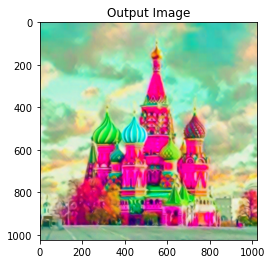

In [51]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, test_img, input_img, style_weight=300000,num_steps=20, content_weight=0.25)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

Building the style transfer model..


<ipython-input-15-9d08329ca7ea>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-15-9d08329ca7ea>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [1]:
Style Loss : 124.371559 Content Loss: 13.036600

run [2]:
Style Loss : 124.367958 Content Loss: 13.036617

run [3]:
Style Loss : 120.802521 Content Loss: 13.052005

run [4]:
Style Loss : 118.941696 Content Loss: 13.042951

run [5]:
Style Loss : 116.571861 Content Loss: 12.987326

run [6]:
Style Loss : 114.340767 Content Loss: 12.880951

run [7]:
Style Loss : 111.380356 Content Loss: 12.825054

run [8]:
Style Loss : 108.078758 Content Loss: 12.776274

run [9]:
Style Loss : 105.132957 Content Loss: 12.734388

run [10]:
Style Loss : 102.048401 Content Loss: 12.700271

run [11]:
Style Loss : 98.613167 Content Loss: 12.699386

run [12]:
Style Loss : 95.174980 Content Loss: 12.735512

run [13]:
Style Loss : 91.905518 Content Loss: 12.796826

run [14]:
Style Loss : 88.657578 Content Loss: 12.888423

run [15]:
Style Loss : 85.486565 Content Loss: 13.011932

run [16]:
Style Loss : 82.439911 Content Loss: 13.139392

run [17]:
Style Loss : 79.614647 Content Loss: 13.262211



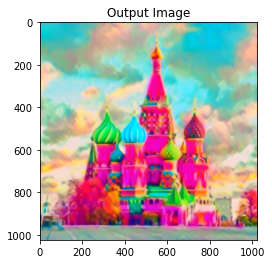

In [52]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, test_img, input_img, style_weight=94000,
                            num_steps=25, content_weight=0.9)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()